# Collision avoidance — drone

## Setup

Import modules.

In [112]:
import numpy as np
from sympy import *
import sympy as sym
import matplotlib.pyplot as plt
import scipy.linalg as linalg

import secrets
import ae353_drone
#import ae353_dronecontrol           # <--- must have a working controller

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

Create and print a seed for the random number generator so it is possible to reproduce the results.

In [113]:
seed = secrets.randbits(32)
print(seed)

2846658556


Create simulator with seed.

In [114]:
simulator = ae353_drone.Simulator(seed=seed)

Add camera views, displayed in their own browser windows.

In [115]:
# Start view
simulator.add_view('my_start_view', 'start')

# Ring 1 view
#simulator.add_ring_view('my_ring_view', 1)

# Top view
#simulator.add_view('my_top_view', 'top')

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


Allow print statements and long computation times (only for development).

In [116]:
simulator.set_rules(
    error_on_print=False,
    error_on_timeout=False,
    error_on_inactive=False,
)

In [117]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

In [118]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

In [119]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

In [120]:
m = np.array([p_x,p_y,p_z,psi,theta,phi,v_x, v_y,v_z,w_x,w_y,w_z])
n = np.array([tau_x,tau_y,tau_z,f_z])

p_xe = p_ye = p_ze = psi_e = theta_e = phi_e = v_xe = v_ye = v_ze =  w_xe = w_ye = w_ze = 0.
tau_xe = tau_ye = tau_ze = f_ze = 0.

A = np.array(f.jacobian(m).subs({p_x:p_xe,p_y:p_ye,p_z:p_ze,psi:psi_e,theta:theta_e,phi:phi_e,v_x:v_xe,v_y:v_ye,v_z:v_ze,w_x:w_xe,w_y:w_ye,w_z:w_ze,\
                        tau_x:tau_xe,tau_y:tau_ye,tau_z:tau_ze,f_z:f_ze})).astype(np.float64)
B = np.array(f.jacobian(n).subs({p_x:p_xe,p_y:p_ye,p_z:p_ze,psi:psi_e,theta:theta_e,phi:phi_e,v_x:v_xe,v_y:v_ye,v_z:v_ze,w_x:w_xe,w_y:w_ye,w_z:w_ze,\
                        tau_x:tau_xe,tau_y:tau_ye,tau_z:tau_ze,f_z:f_ze})).astype(np.float64)
print(A)
print(B)
W_c = np.block([B,A@B,np.linalg.matrix_power(A,2)@B,np.linalg.matrix_power(A,3)@B,
                np.linalg.matrix_power(A,4)@B,np.linalg.matrix_power(A,5)@B,np.linalg.matrix_power(A,6)@B,np.linalg.matrix_power(A,7)@B,
                np.linalg.matrix_power(A,8)@B,np.linalg.matrix_power(A,9)@B,np.linalg.matrix_power(A,10)@B,np.linalg.matrix_power(A,11)@B])
print(f'W_c rank: {np.linalg.matrix_rank(W_c)}, col num: {A.shape[0]}')

[[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
[[  0.          0.          0.          0.       ]
 [  0.          0.          0.          0.      

In [121]:
m = sym.Matrix([p_x,p_y,p_z,psi,theta,phi,v_x, v_y,v_z,w_x,w_y,w_z])
n = sym.Matrix([tau_x,tau_y,tau_z,f_z])
C_sym = g.jacobian(m)
D_sym = g.jacobian(n)

subs_dict = {
    p_x: 0.0, p_y: 0.0, p_z: 0.0,
    psi: 0.0, theta: 0.0, phi: 0.0,
    v_x: 0.0, v_y: 0.0, v_z: 0.0,
    w_x: 0.0, w_y: 0.0, w_z: 0.0
}
C_eval = C_sym.evalf(subs=subs_dict)
D_eval = D_sym.evalf(subs=subs_dict)

C = np.array(C_eval.tolist()).astype(np.float64)
D = np.array(D_eval.tolist()).astype(np.float64)
print(C)
print(D)

W_o = np.block([[C],[C@A], [C@np.linalg.matrix_power(A,2)],[C@np.linalg.matrix_power(A,3)],\
                 [C@np.linalg.matrix_power(A,4)],[C@np.linalg.matrix_power(A,5)], [C@np.linalg.matrix_power(A,6)],
                 [C@np.linalg.matrix_power(A,7)], [C@np.linalg.matrix_power(A,8)], [C@np.linalg.matrix_power(A,9)],
                 [C@np.linalg.matrix_power(A,10)], [C@np.linalg.matrix_power(A,11)]])
print(f'W_o rank: {np.linalg.matrix_rank(W_o)}, col num: {A.shape[0]}')

[[ 1.     0.     0.    -0.175  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.     0.     0.175  0.     0.     0.     0.
   0.     0.   ]
 [ 1.     0.     0.     0.175  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.     0.    -0.175  0.     0.     0.     0.
   0.     0.   ]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
W_o rank: 12, col num: 12


In [222]:
Qc = np.array([[100,0,0,0,0,0,0,0,0,0,0,0],
               [0,100,0,0,0,0,0,0,0,0,0,0],
               [0,0,100,0,0,0,0,0,0,0,0,0],
               [0,0,0,10,0,0,0,0,0,0,0,0],
               [0,0,0,0,10,0,0,0,0,0,0,0],
               [0,0,0,0,0,10,0,0,0,0,0,0],
               [0,0,0,0,0,0,1,0,0,0,0,0],
               [0,0,0,0,0,0,0,1,0,0,0,0],
               [0,0,0,0,0,0,0,0,1,0,0,0],
               [0,0,0,0,0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,0,0,0,0,1,0],
               [0,0,0,0,0,0,0,0,0,0,0,1]])
Rc = np.array([[1,0,0,0],
               [0,1,0,0],
               [0,0,1,0],
               [0,0,0,1]])*100

Pc = linalg.solve_continuous_are(A,B,Qc,Rc)
K = linalg.inv(Rc)@B.T@Pc

Qo = np.array([[1,0,0,0,0,0,0,0,0,0,0,0],
               [0,1,0,0,0,0,0,0,0,0,0,0],
               [0,0,1,0,0,0,0,0,0,0,0,0],
               [0,0,0,1,0,0,0,0,0,0,0,0],
               [0,0,0,0,1,0,0,0,0,0,0,0],
               [0,0,0,0,0,1,0,0,0,0,0,0],
               [0,0,0,0,0,0,1,0,0,0,0,0],
               [0,0,0,0,0,0,0,1,0,0,0,0],
               [0,0,0,0,0,0,0,0,1,0,0,0],
               [0,0,0,0,0,0,0,0,0,1,0,0],
               [0,0,0,0,0,0,0,0,0,0,1,0],
               [0,0,0,0,0,0,0,0,0,0,0,1]])
Ro = np.array([[1,0,0,0,0,0],
               [0,1,0,0,0,0],
               [0,0,1,0,0,0],
               [0,0,0,1,0,0],
               [0,0,0,0,1,0],
               [0,0,0,0,0,1]])

Po = linalg.solve_continuous_are(A.T, C.T, Qo, Ro)
L = Po @ C.T @ np.linalg.inv(Ro)

print(f'K matrix')
print(K)
print(f'L matrix')
print(L)

K matrix
[[-0.         -1.          0.         -0.         -0.          1.10672658
  -0.         -0.48541975 -0.          0.1228452  -0.         -0.        ]
 [ 1.          0.          0.         -0.          1.10672658 -0.
   0.48541975  0.          0.         -0.          0.1228452   0.        ]
 [ 0.          0.          0.          0.31622777  0.         -0.
   0.          0.          0.         -0.          0.          0.11193669]
 [-0.         -0.          1.          0.          0.          0.
   0.          0.          1.00498756 -0.          0.          0.        ]]
L matrix
[[ 2.97537602 -0.          0.          2.97537602 -0.         -0.        ]
 [-0.          2.92711379 -0.21976816 -0.          2.92711379  0.21976816]
 [ 0.          0.          1.09868411 -0.          0.          1.09868411]
 [-2.13087076  0.         -0.          2.13087076  0.          0.        ]
 [ 1.30543174 -0.          0.          1.30543174 -0.         -0.        ]
 [ 0.         -1.25581808  0.30429

Show controller template. The actual controller used in this example comes from `ae353_dronecontrol.py`.

**NOTE. I didn't publish the version of `ae353_dronecontrol.py` that was used in class, rather just the template version. If you want this notebook to work, you'll need to modify `ae353_dronecontrol.py` so that it works!**

## With Collision Avoidance?? Edited Too Much To Decifer

In [225]:
import numpy as np

class Controller:
    def __init__(self, K_att=1.0, K_rep=1.0, K_des=1.0, r_drone=0.25):
        # System matrices and LQR/Observer gains
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        # Equilibrium states and inputs
        self.me = np.zeros(12)                      
        self.ne = np.array([0., 0., 0., 4.905])  # Corrected equilibrium thrust (m*g = 0.5*9.81)

        # Potential field parameters
        self.K_att = K_att
        self.K_rep = K_rep
        self.K_des = K_des
        self.r_drone = r_drone
        self.r_ring = 1.0  # radius of the small ring

        # Internal variables
        self.xhat = np.zeros(12)
        self.xdes = np.zeros(12)
        self.ring = np.zeros(3)
        self.emax = 1.0  # maximum step size for pdes update

        self.variables_to_log = ['xhat', 'xdes', 'ring']

    def get_color(self):
        return [1., 0., 0.]  # Red drone color

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.zeros(12)
        self.xhat[0] = p_x
        self.xhat[1] = p_y
        self.xhat[2] = p_z
        self.xhat[3] = yaw

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
        self.ring = np.array(pos_ring)

    # Get desired state
        self.xdes = self.get_xdes(self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)

    # Controller input
        u = -self.K @ (self.xhat - self.xdes)

    # Add equilibrium thrust to f_z
        u[3] += self.ne[3]

    # Use pos_markers for measurement
        y_meas = np.array(pos_markers).flatten()  # Flatten to 1D if needed
        y_hat = self.C @ self.xhat                # Predicted sensor output

    # Observer update
        dt = 0.01
        dxhat = self.A @ (self.xhat - self.me) + self.B @ (u - self.ne) + self.L @ (y_meas - y_hat)
        self.xhat += dxhat * dt

    # Motor outputs
        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3]

        return tau_x, tau_y, tau_z, f_z

# Measurement model (corrected)
        #y = self.C @ self.xhat

        # Observer update
        #dt = 0.01
        #dxhat = self.A @ (self.xhat - self.me) + self.B @ (u - self.ne) + self.L @ (y - self.C @ (self.xhat - self.me))
        #self.xhat += dxhat * dt

    def get_xdes(self, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        phat = xhat[0:3]  # Estimated 3D position

        epsilon = 1e-3  # small value to prevent division by near zero

    # --- Goal selection ---
        if not is_last_ring:
        # Normal operation: goal is next ring center
            pgoal = np.array(pos_ring)
        else:
        # After last ring: goal is starting position, descend slowly
            pgoal = self.start_pos.copy()

        # Gradually lower the altitude
            if phat[2] > 0.15:
        # High enough: descend slowly
                pgoal[2] = phat[2] - 0.01
            else:
        # Close to ground: stop commanding descent
                pgoal[2] = phat[2]

    # --- Step size limiter ---
        p_err = pgoal - phat
        norm_p_err = np.linalg.norm(p_err)

        if norm_p_err > self.emax:
            pgoal = phat + self.emax * (p_err / norm_p_err)

    ##############################
    # Attractive gradient
        grad_h_att = self.K_att * (phat - pgoal) / np.linalg.norm(phat - pgoal)

    # Initialize repulsive gradient
        grad_h_rep = np.zeros(3)

    # Repulsion from other drones
        for q in pos_others:
            pobst = q + self.r_drone * (phat - q) / np.linalg.norm(phat - q)
            d = np.linalg.norm(phat - pobst) - self.r_drone
            if d < epsilon:
                d = epsilon
            grad_d = (phat - pobst) / np.linalg.norm(phat - pobst)
            grad_h_rep += -self.K_rep * (1 / d**2) * grad_d

    # Repulsion from ring plane (except at hole)
        plane_normal = dir_ring / np.linalg.norm(dir_ring)
        q_plane = np.array(pos_ring)

        v_rel = phat - q_plane
        v_n = np.dot(v_rel, plane_normal) * plane_normal
        v_t = v_rel - v_n

        if np.linalg.norm(v_t) > self.r_ring:
            d_plane = np.abs(np.dot(phat - q_plane, plane_normal))
            if d_plane < epsilon:
                d_plane = epsilon
            grad_h_rep += self.K_rep * (plane_normal / (d_plane**2))

    # Repulsion from ground
        d_ground = phat[2]
        if d_ground > 0:
            if d_ground < epsilon:
                d_ground = epsilon
            grad_h_rep[2] += self.K_rep * (1 / d_ground**2)

    ##############################
    # Total gradient
        grad_h = grad_h_att + grad_h_rep

    # Desired position update
        pdes = phat - self.K_des * grad_h

    # Step size limit after gradient
        delta_p = pdes - phat
        if np.linalg.norm(delta_p) > self.emax:
            pdes = phat + self.emax * (delta_p / np.linalg.norm(delta_p))

    # Build desired state
        xdes = np.zeros(12)
        xdes[0:3] = pdes

        return xdes


## Trying Without Collision Avoidance

In [238]:
import numpy as np

class Controller:
    def __init__(self, K_att=1.0, K_des=1.0):
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        self.me = np.zeros(12)
        self.ne = np.array([0., 0., 0., 4.905])

        self.K_att = K_att
        self.K_des = K_des
        self.emax = 1.0

        self.variables_to_log = ['xhat', 'xdes', 'ring']

    def get_color(self):
        return [1., 0., 0.]

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.zeros(12)
        self.xhat[0] = p_x
        self.xhat[1] = p_y
        self.xhat[2] = p_z
        self.xhat[3] = yaw
        self.start_pos = np.array([p_x, p_y, p_z])

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
        ring = np.array(pos_ring)

        # Use midpoint of markers as position measurement
        pos_left = np.array(pos_markers[:3])
        pos_right = np.array(pos_markers[3:])
        pos_meas = 0.5 * (pos_left + pos_right)
        y_meas = np.concatenate([pos_meas, [0, 0, 0]])  # yaw/pitch/roll = 0

        # Update xhat[0:3] to current position measurement
        self.xhat[0:3] = pos_meas

        # Get desired state
        self.xdes = self.get_xdes(self.xhat, pos_ring, dir_ring, is_last_ring, pos_others)

        # Controller
        u = -self.K @ (self.xhat - self.xdes)
        u[3] += self.ne[3]

        # Observer update
        dt = 0.04
        y_hat = self.C @ self.xhat
        dxhat = self.A @ (self.xhat - self.me) + self.B @ (u - self.ne) + self.L @ (y_meas - y_hat)
        self.xhat += dxhat * dt

        tau_x = u[0]
        tau_y = u[1]
        tau_z = u[2]
        f_z = u[3]

        return tau_x, tau_y, tau_z, f_z

    def get_xdes(self, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        phat = xhat[0:3]

        if not is_last_ring:
            pgoal = np.array(pos_ring)
        else:
            pgoal = self.start_pos.copy()  # Return to starting position
            pgoal[2] = phat[2] - 0.01 if phat[2] > 0.15 else phat[2]  # Slowly descend

        p_err = pgoal - phat
        if np.linalg.norm(p_err) > self.emax:
            pdes = phat + self.emax * (p_err / np.linalg.norm(p_err))
        else:
            pdes = pgoal

        xdes = np.zeros(12)
        xdes[0:3] = pdes
        return xdes


Rearrange the rings.

In [239]:
simulator.place_rings()

## Without collision avoidance

This controller is what we might start with before adding a planner with collision avoidance.

In [224]:
#class Controller(ae353_dronecontrol.Controller):
    def get_color(self):
        return [1., 0., 0.]
    
    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        # Get estimated position
        phat = xhat[0:3]
       
       # Get desired position
        pdes = pos_ring
        
        # Make sure desired position is not too far away
        emax = 1.
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
        
        # Get desired state
        xdes = np.zeros(12)
        xdes[0:3] = pdes
        return xdes

IndentationError: unexpected indent (3786192098.py, line 2)

Clear all drones.

In [240]:
simulator.clear_drones()

Add drones to simulator.

In [241]:
num_drones = 1
for i in range(num_drones):
    simulator.add_drone(Controller, f'test_{i + 1}', 'template.png')

Reset the simulator.

In [242]:
simulator.reset()

Run the simulator.

In [243]:
simulator.run(max_time=25., print_debug=True)

KeyboardInterrupt: 

## With collision avoidance

This controller is a template for adding a planner with collision avoidance.

In [23]:
class AvoidanceController(ae353_dronecontrol.Controller):
    def get_color(self):
        return [0., 1., 0.]
    
    def get_xdes(self, t, xhat, pos_ring, dir_ring, is_last_ring, pos_others):
        # Get estimated position
        phat = xhat[0:3]

        # Choose goal
        pgoal = pos_ring
        
        ##############################
        
        # Define parameters
        k_att = 1.0
        k_rep = 1.0
        k_des = 1.0
        r_drone = 0.25  # <-- radius of a sphere that would completely contain each drone
        r_ring = 1.0    # <-- radius of each small ring
        
        # Get attractive part
        grad_h_att = k_att * ((phat - pgoal) / np.linalg.norm(phat - pgoal))
        
        # Get repulsive part
        # - Initialize the gradient
        grad_h_rep = np.zeros(3)
        # - Add repulsive part for each other drone
        for q in pos_others:
            pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
            dgrad = (phat - pobst) / np.linalg.norm(phat - pobst)
            d = np.linalg.norm(phat - pobst) - r_drone
            grad_h_rep += - k_rep * (1 / d**2) * dgrad
        # - Add repulsive part for next ring
        grad_h_rep += np.zeros(3)           # <-- REPLACE WITH YOUR CODE
        # - Add repulsive part for ground
        grad_h_rep += np.zeros(3)           # <-- REPLACE WITH YOUR CODE
        
        # Get desired position
        pdes = phat - k_des * (grad_h_att + grad_h_rep)
        
        ##############################
        
        # Make sure desired position is not too far away
        emax = 1.
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))
        
        # Get desired state
        xdes = np.zeros(12)
        xdes[0:3] = pdes
        return xdes

NameError: name 'ae353_dronecontrol' is not defined

Clear all drones.

In [92]:
simulator.clear_drones()

Add drones to simulator.

In [41]:
num_drones = 5
for i in range(num_drones):
    simulator.add_drone(AvoidanceController, f'test_{i + 1}', 'template.png')

NameError: name 'AvoidanceController' is not defined

Reset the simulator.

In [44]:
simulator.reset()

Run the simulator.

In [45]:
simulator.run(max_time=5., print_debug=True)


drone test_1 is out of bounds (turning it off)

Simulated 51 time steps in 2.0431 seconds (24.9619 time steps per second)


### Show results

Get data.

In [145]:
data = simulator.get_data('test_1')

Plot results (position only).

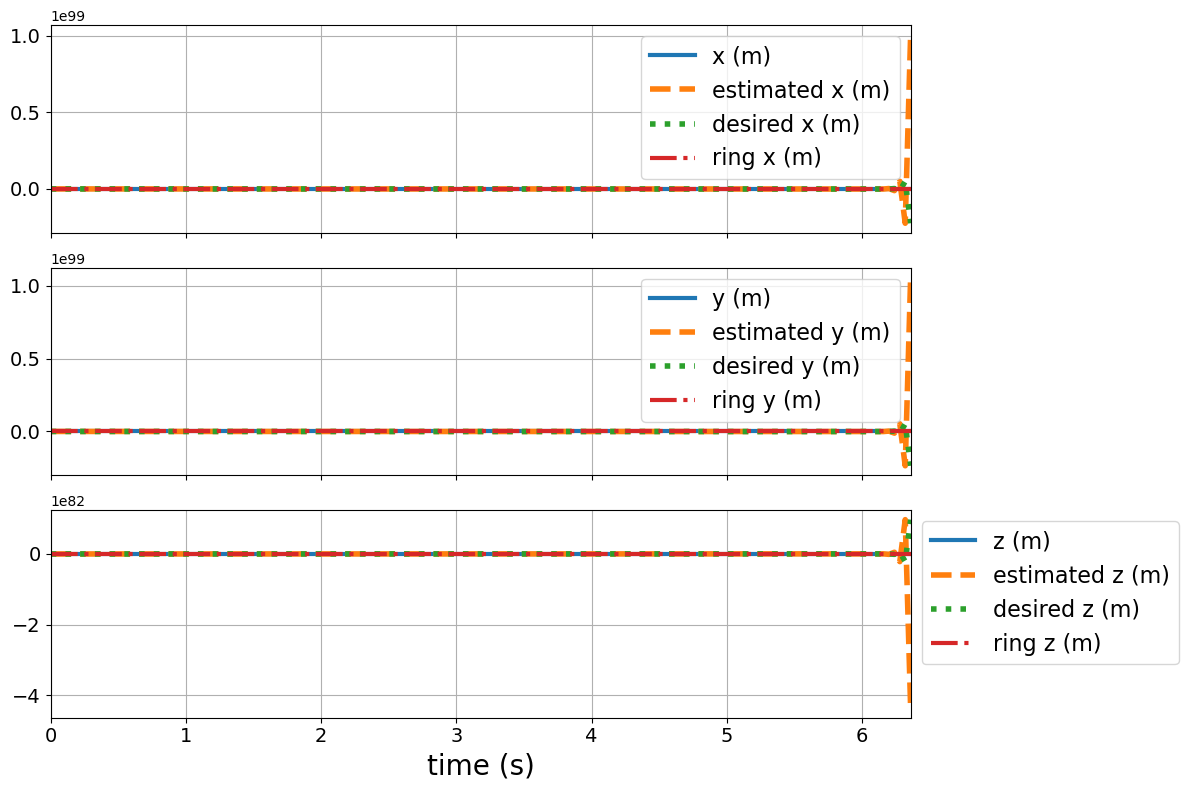

In [146]:
p_x_est = data['xhat'][:, 0]
p_y_est = data['xhat'][:, 1]
p_z_est = data['xhat'][:, 2]

p_x_des = data['xdes'][:, 0]
p_y_des = data['xdes'][:, 1]
p_z_des = data['xdes'][:, 2]

p_x_ring = data['ring'][:, 0]
p_y_ring = data['ring'][:, 1]
p_z_ring = data['ring'][:, 2]

# Create a figure with subplots that all share the same x-axis
fig, (ax_px, ax_py, ax_pz) = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

ax_px.plot(data['t'], data['p_x'], label='x (m)', linewidth=3)
ax_px.plot(data['t'], p_x_est, '--', label='estimated x (m)', linewidth=4)
ax_px.plot(data['t'], p_x_des, ':', label='desired x (m)', linewidth=4)
ax_px.plot(data['t'], p_x_ring, '-.', label='ring x (m)', linewidth=3)
ax_px.grid()
ax_px.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_px.tick_params(labelsize=14)

ax_py.plot(data['t'], data['p_y'], label='y (m)', linewidth=3)
ax_py.plot(data['t'], p_y_est, '--', label='estimated y (m)', linewidth=4)
ax_py.plot(data['t'], p_y_des, ':', label='desired y (m)', linewidth=4)
ax_py.plot(data['t'], p_y_ring, '-.', label='ring y (m)', linewidth=3)
ax_py.grid()
ax_py.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_py.tick_params(labelsize=14)

ax_pz.plot(data['t'], data['p_z'], label='z (m)', linewidth=3)
ax_pz.plot(data['t'], p_z_est, '--', label='estimated z (m)', linewidth=4)
ax_pz.plot(data['t'], p_z_des, ':', label='desired z (m)', linewidth=4)
ax_pz.plot(data['t'], p_z_ring, '-.', label='ring z (m)', linewidth=3)
ax_pz.grid()
ax_pz.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pz.tick_params(labelsize=14)

# Set shared x-axis properties
ax_pz.set_xlabel('time (s)', fontsize=20)
ax_pz.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()